# Training EfficientNet
We are now specifically implementing for EfficientNet

## Loading from TFRecords

In [6]:
import os

os.environ["KERAS_BACKEND"] = "tensorflow"

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import keras
import tensorflow as tf
from tensorflow import data as tf_data
from tensorboard.plugins.hparams import api as hp

from sklearn.model_selection import train_test_split

from preprocess_common import *

from record_save_load import *

In [3]:
class_names=['Human', 'AI']
AUTO = tf_data.AUTOTUNE # Parallelize data loading
#Hyperparameters
BUFFER_SIZE = 1024
BATCH_SIZE = 32
IMG_SIZE = (380,380)

SEED = 44

In [8]:
eff_train_ds = load_tfrecord("records/efficientnet_train.tfrecord", BATCH_SIZE, "efficientnet").repeat()
eff_val_ds = load_tfrecord("records/efficientnet_val.tfrecord", BATCH_SIZE, "efficientnet")

(380, 380, 3)


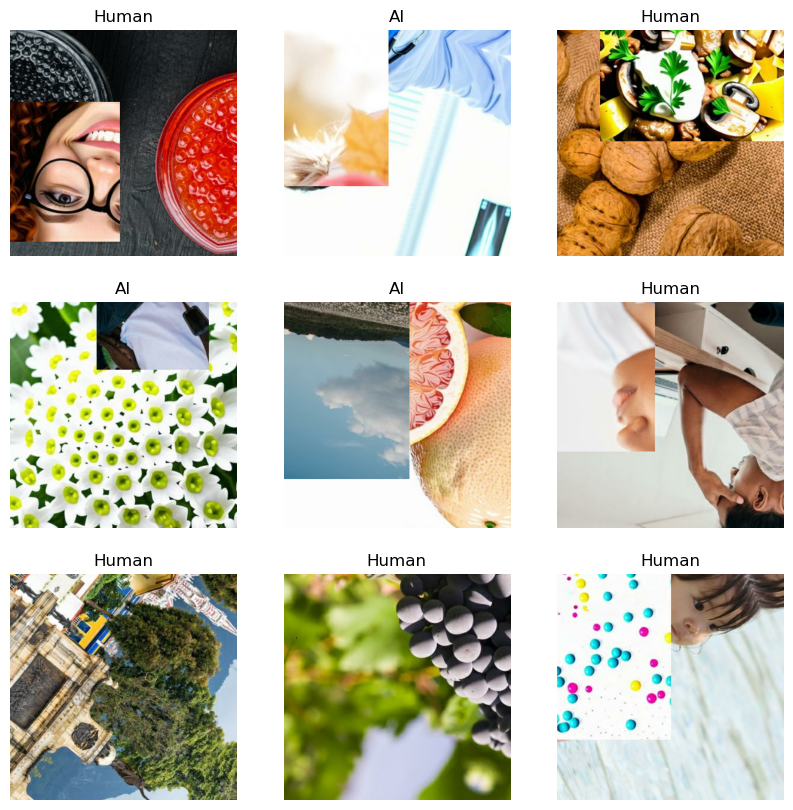

In [9]:

image_batch, label_batch = next(iter(eff_train_ds))
print(image_batch[0].shape)
plt.figure(figsize=(10, 10))
for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.title(class_names[np.argmax(label_batch[i])])
    plt.imshow(image_batch[i])
    plt.axis("off")


## Initialize Base EfficientNet Model

In [7]:
base_effnet_model = keras.applications.EfficientNetB4(input_shape=(*IMG_SIZE, 3), include_top=False, weights='imagenet')
base_effnet_model.trainable = False

base_effnet_model.summary()

71686520/71686520 ━━━━━━━━━━━━━━━━━━━━ 3s 0us/step


Model: "efficientnetb4"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 380, 380,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ rescaling           │ (None, 380, 380,  │          0 │ input_layer[0][0] │
│ (Rescaling)         │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ normalization       │ (None, 380, 380,  │          7 │ rescaling[0][0]   │
│ (Normalization)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ rescaling_1         │ (None, 380, 380,  │          0 │ normalization[0]… │
│ (Rescaling)         │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_conv_pad       │ (None, 381, 381,  │          0 │ rescaling_1[0][0] │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_conv (Conv2D)  │ (None, 190, 190,  │      1,296 │ stem_conv_pad[0]… │
│                     │ 48)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_bn             │ (None, 190, 190,  │        192 │ stem_conv[0][0]   │
│ (BatchNormalizatio… │ 48)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_activation     │ (None, 190, 190,  │          0 │ stem_bn[0][0]     │
│ (Activation)        │ 48)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_dwconv      │ (None, 190, 190,  │        432 │ stem_activation[… │
│ (DepthwiseConv2D)   │ 48)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_bn          │ (None, 190, 190,  │        192 │ block1a_dwconv[0… │
│ (BatchNormalizatio… │ 48)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_activation  │ (None, 190, 190,  │          0 │ block1a_bn[0][0]  │
│ (Activation)        │ 48)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_squeeze  │ (None, 48)        │          0 │ block1a_activati… │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_reshape  │ (None, 1, 1, 48)  │          0 │ block1a_se_squee… │
│ (Reshape)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_reduce   │ (None, 1, 1, 12)  │        588 │ block1a_se_resha… │
│ (Conv2D)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_expand   │ (None, 1, 1, 48)  │        624 │ block1a_se_reduc… │
│ (Conv2D)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_excite   │ (None, 190, 190,  │          0 │ block1a_activati… │
│ (Multiply)          │ 48)               │            │ block1a_se_expan… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_project_co… │ (None, 190, 190,  │      1,152 │ block1a_se_excit

 Total params: 17,673,823 (67.42 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 17,673,823 (67.42 MB)

## Transfer Learning for new Classfication Head
### Hyperparameter grid search

Here we utilize a Grid Search to optimize for the width of the hidden unit in the new classfication head as well as the dropout rate.

Because of computational constraints we fix Epochs and instead use Early Stopping, and we fix the initial Learning Rate as we're using Cosine Annealing/Decay, as well as the previously fixed Batch Size as well.

In [9]:
EPOCHS = 32
LEARNING_RATE = 0.05
HP_NUM_UNITS = hp.HParam('num_units', hp.Discrete([64, 128, 256]))
HP_DROPOUT = hp.HParam('dropout', hp.RealInterval(0.1, 0.3))

In [ ]:
def effnet_model(hparams):
    inputs = keras.Input(shape=(*IMG_SIZE, 3))
    x = base_effnet_model(inputs, training=False)
    x = keras.layers.GlobalAveragePooling2D()(x)
    x = keras.layers.Dense(hparams[HP_NUM_UNITS], activation='relu')(x)
    x = keras.layers.Dropout(hparams[HP_DROPOUT], seed=SEED)(x)
    outputs = keras.layers.Dense(2, activation='softmax')(x)
    effnet_model = keras.Model(inputs, outputs)

    first_decay_steps = 10
    lr_decayed_fn = (
        keras.optimizers.schedules.CosineDecayRestarts(
            LEARNING_RATE,
            first_decay_steps,
            alpha=0.001))
        
    effnet_model.compile(optimizer=keras.optimizers.Adam(lr_decayed_fn),
                    loss=keras.losses.CategoricalCrossentropy(),
                    metrics=[keras.metrics.AUC(multi_label=True),
                            keras.metrics.F1Score("macro")]) 

    effnet_model.fit(
        eff_train_ds,
        steps_per_epoch=1999,
        epochs=EPOCHS,
        callbacks=[
          keras.callbacks.EarlyStopping(monitor='val_f1_score', patience=3),
          keras.callbacks.ModelCheckpoint(f'efficientnet_model_{hparams[HP_NUM_UNITS]}_{hparams[HP_DROPOUT]}.keras', save_best_only=True),
          keras.callbacks.TensorBoard(log_dir=f'logs/efficientnet_model_{hparams[HP_NUM_UNITS]}_{hparams[HP_DROPOUT]}'),
          hp.KerasCallback(f'logs/efficientnet_model_{hparams[HP_NUM_UNITS]}_{hparams[HP_DROPOUT]}/hparam_tuning', hparams)
        ],
        validation_data=eff_val_ds
    )
    return effnet_model
models = []
# Grid search over hyperparameters
for num_units in HP_NUM_UNITS.domain.values:
    for dropout_rate in [HP_DROPOUT.domain.min_value, HP_DROPOUT.domain.max_value]:
        hparams = {
            HP_NUM_UNITS: num_units,
            HP_DROPOUT: dropout_rate,
        }
        print(f"Running hparam set {hparams}")
        models.append(effnet_model(hparams))

Running hparam set {HParam(name='num_units', domain=Discrete([64, 128, 256]), display_name=None, description=None): 64, HParam(name='dropout', domain=RealInterval(0.1, 0.3), display_name=None, description=None): 0.1}
Epoch 1/32


I0000 00:00:1742359183.931104    2309 service.cc:146] XLA service 0x7f5bd001c2e0 initialized for platform ROCM (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1742359183.931152    2309 service.cc:154]   StreamExecutor device (0): AMD Radeon RX 7900 XTX, AMDGPU ISA version: gfx1100
2025-03-19 00:39:44.406456: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1742359196.088562    2309 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


1999/1999 ━━━━━━━━━━━━━━━━━━━━ 0s 133ms/step - auc: 0.8174 - f1_score: 0.7414 - loss: 0.7385

2025-03-19 00:45:27.805902: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2025-03-19 00:45:27.806481: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]
/home/david/.pyenv/versions/3.12.9/envs/3.12stad68/lib/python3.12/site-packages/keras/src/trainers/epoch_iterator.py:151: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


1999/1999 ━━━━━━━━━━━━━━━━━━━━ 356s 167ms/step - auc: 0.8174 - f1_score: 0.7414 - loss: 0.7385 - val_auc: 0.9129 - val_f1_score: 0.8170 - val_loss: 0.5235
Epoch 2/32
1999/1999 ━━━━━━━━━━━━━━━━━━━━ 318s 159ms/step - auc: 0.8571 - f1_score: 0.7702 - loss: 0.5692 - val_auc: 0.9145 - val_f1_score: 0.8403 - val_loss: 0.6576
Epoch 3/32


2025-03-19 00:50:47.147510: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]


1999/1999 ━━━━━━━━━━━━━━━━━━━━ 320s 160ms/step - auc: 0.8781 - f1_score: 0.7965 - loss: 0.4994 - val_auc: 0.8735 - val_f1_score: 0.8280 - val_loss: 2.3519
Epoch 4/32
 429/1999 ━━━━━━━━━━━━━━━━━━━━ 3:21 129ms/step - auc: 0.8046 - f1_score: 0.7533 - loss: 0.9215

KeyboardInterrupt: 

## Fine Tuning Convolutional Layer

Here we don't want to use Cosine Decay as we only want to very slowly adjust the weights instead of taking big strides

In [ ]:
EPOCHS = 20
LEARNING_RATE = 1e-5

In [ ]:
base_effnet_model.trainable = True

# TODO: FROM models = [] select the best model from the training above and fine tune it
# IDK how it works when the model is in a function since the tutorial doesnt call a function but keeps the model in the global scope
# Does it still keep a reference to the base_effnet_model? So if I use base_effnet_model.trainable = True, will it affect all the models?
    # If so, keep the best model in the list and fine tune that one
# https://keras.io/guides/transfer_learning/#do-a-round-of-finetuning-of-the-entire-model 

# effnet_model.compile(optimizer=keras.optimizers.Adam(LEARNING_RATE),
#                 loss=keras.losses.CategoricalCrossentropy(),
#                 metrics=[keras.metrics.AUC(multi_label=True),
#                             keras.metrics.F1Score("macro")])

# effnet_model.fit(eff_train_ds, 
#                  epochs=EPOCHS, 
#                  callbacks=[
#                     keras.callbacks.EarlyStopping(monitor='val_loss', patience=3),
#                     keras.callbacks.ModelCheckpoint(f'efficientnet_model_fine_tuned.keras', save_best_only=True),
#                     keras.callbacks.TensorBoard(log_dir='logs/efficientnet_fine_tuned'),
# 				],
#                  validation_data=eff_val_ds)